# Fraud Detection with Random Forest

This notebook demonstrates a machine learning approach to detect fraudulent transactions using a Random Forest classifier. The project involves feature engineering, model training, and evaluation to build an effective fraud detection system.

## Table of Contents
1. [Loading packages and data](#Loading-packages-and-data)
2. [Feature Engineering](#Feature-Engineering)
3. [Applying Transformations to Test Data](#Applying-Transformations-to-Test-Data)
4. [Model Training](#Model-Training)
   - [On stratified random split data](#Cross-validation-on--stratified-random-split-data)
   - [Time series split data](#CV-on-time-series-split-data)
5. [Model Evaluation](#Model-Evaluation)   
   - [On stratified random split data](#On--stratified-random-split)    
   - [On time series split data](#On-time-series-data)
6. [Debugging poor performance on time-split data](#Debugging-the-poor-performance-in-time-stamp-based-split)

## Loading packages and data

In [1]:
import pandas as pd
from imblearn.ensemble import BalancedRandomForestClassifier 
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold, cross_validate, TimeSeriesSplit
from sklearn.feature_extraction import FeatureHasher
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from scipy.stats import chi2_contingency
import socket
import struct
import ipaddress
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
# setting options to improve readability
pd.options.display.max_columns = 20
pd.options.display.max_rows = 20
pd.options.display.max_colwidth = 80
np.set_printoptions(precision=4, suppress=True)

The first step is to load the dataset and perform a preliminary analysis to understand its structure and the distribution of fraudulent vs. non-fraudulent transactions.

In [3]:
df = pd.read_csv('./Fraud_Data_final.csv')
df.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,class,ip_address_str,country
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,0,43.173.1.96,Japan
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,0,20.225.83.219,United States
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,1,156.64.132.28,United States
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,0,228.234.6.235,United States
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,0,24.197.75.141,United States


In [4]:
print(f"Shape: {df.shape}")
print(df['class'].value_counts())
n_Nfraud, n_fraud = df['class'].value_counts()
print(f"Fraud to non-fraud transactions: {n_fraud/n_Nfraud}")

Shape: (151112, 12)
class
0    136961
1     14151
Name: count, dtype: int64
Fraud to non-fraud transactions: 0.10332138345952498


In [5]:
# This is time-series data. In production enviroment, future transaction details will not be available
# However, we can add a few more features that are computed purely based on past
# Then we can split the data based on training data that is purely in the past and test data that is purely in the future
# The data rows in the future slice will carry the information from the past.
# This is a reasonable assumption in the production environment
# Convert time columns to datetime objects
df = df.sort_values('purchase_time').copy()
df['signup_time'] = pd.to_datetime(df['signup_time'])
df['purchase_time'] = pd.to_datetime(df['purchase_time'])

# implement earlier transaction counts for given device_id and ip_address
df['dev_prev_txns'] = df.groupby('device_id').cumcount()
df['ip_prev_txns'] = df.groupby('ip_address_str').cumcount()

#  Time since last txn
df['dev_prev_ts'] = df.groupby('device_id')['purchase_time'].shift(1)
df['secs_since_dev'] = (df['purchase_time'] - df['dev_prev_ts']).dt.total_seconds().fillna(1e9)

# keeping only top 25 countries and rest as 'other'
top_countries = df['country'].value_counts().nlargest(25).index
df['IP_country_encoded'] = df['country'].where(df['country'].isin(top_countries), other='Other')


In [6]:
df.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,class,ip_address_str,country,dev_prev_txns,ip_prev_txns,dev_prev_ts,secs_since_dev,IP_country_encoded
115086,309557,2015-01-01 00:00:43,2015-01-01 00:00:44,14,BBPACGBUVJUXF,Ads,Chrome,F,38,1,119.75.87.223,United States,0,0,NaT,1.000000e+09,United States
41990,124539,2015-01-01 00:00:44,2015-01-01 00:00:45,14,BBPACGBUVJUXF,Ads,Chrome,F,38,1,119.75.87.223,Taiwan; Republic of China (ROC),1,1,2015-01-01 00:00:44,1.000000e+00,Taiwan; Republic of China (ROC)
134836,161246,2015-01-01 00:00:45,2015-01-01 00:00:46,14,BBPACGBUVJUXF,Ads,Chrome,F,38,1,119.75.87.223,United States,2,2,2015-01-01 00:00:45,1.000000e+00,United States
24572,356414,2015-01-01 00:00:46,2015-01-01 00:00:47,14,BBPACGBUVJUXF,Ads,Chrome,F,38,1,119.75.87.223,Venezuela,3,3,2015-01-01 00:00:46,1.000000e+00,Other
106160,338656,2015-01-01 00:00:47,2015-01-01 00:00:48,14,BBPACGBUVJUXF,Ads,Chrome,F,38,1,119.75.87.223,Malaysia,4,4,2015-01-01 00:00:47,1.000000e+00,Other


### Data Splitting

1. Since this is time series, we should consider training on past data and testing it on the future data. So we will do such a split based on the 'purchase_time' chronological order rows.
2. A caveat to this strategy is that features such as device_id or ip_address may appear in both training and testing sets. This could allow the model to 'memorize' specific indentifiers, potentially leading information leakage.
3. So I will consider both ways of splitting with similar feature engineering. 

To prevent data leakage, the data is split into training and testing sets before any feature engineering. Stratified splitting is used to maintain the same proportion of fraudulent and non-fraudulent transactions in both the training and testing sets.
  

In [7]:
cutoff = int(len(df) * 0.8) # Latest 20% of data for the final test
train_df_time, test_df_time = df.iloc[:cutoff].copy(), df.iloc[cutoff:].copy()

In [8]:
# Data splitting to prevent data leakage
# Using stratified splitting to maintain the proportion of fraud vs. non-fraud.
stratified_splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in stratified_splitter.split(df, df['class']):
    train_df = df.iloc[train_index].copy()
    test_df = df.iloc[test_index].copy()

## Feature Engineering

### a) Time-Based Features
Time-based features are created to capture temporal patterns. The time difference between sign-up and purchase is calculated, and the hour of the day of the purchase is extracted as a cyclical feature.

In [9]:
# a) Time-Based Features
# Calculate the time difference between sign-up and purchase in seconds.
train_df.loc[:, 'secs_since_signup'] = (train_df['purchase_time'] - train_df['signup_time']).dt.total_seconds()
# Extract cyclical features like hour of the day
train_df.loc[:, 'purchase_hour'] = train_df['purchase_time'].dt.hour
train_df.loc[:, 'purchase_day'] = train_df['purchase_time'].dt.day
train_df.loc[:, 'purchase_month'] = train_df['purchase_time'].dt.month
train_df.head()



,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,class,...,country,dev_prev_txns,ip_prev_txns,dev_prev_ts,secs_since_dev,IP_country_encoded,secs_since_signup,purchase_hour,purchase_day,purchase_month
138197,117296,2015-02-09 10:57:57,2015-05-17 14:12:10,16,QNXCOUPOQDLCL,Direct,Chrome,M,31,0,...,United Kingdom,1,0,2015-02-06 01:52:20,8.684390e+06,United Kingdom,8392453.0,14,17,5
43076,214882,2015-04-20 19:01:55,2015-07-24 23:15:06,32,KUZCDUJXEMAZM,SEO,Safari,M,23,0,...,Viet Nam,0,0,NaT,1.000000e+09,Other,8223191.0,23,24,7
102776,73834,2015-07-09 04:33:26,2015-10-11 04:00:29,35,GSZFXRRBDXPAS,SEO,Chrome,F,39,0,...,United States,0,0,NaT,1.000000e+09,United States,8119623.0,4,11,10
122409,280252,2015-01-30 19:08:42,2015-04-12 14:20:39,28,JCZMYSCYHQJYX,Direct,IE,F,21,0,...,United States,0,0,NaT,1.000000e+09,United States,6203517.0,14,12,4
37774,167375,2015-08-03 02:17:23,2015-09-07 00:09:54,43,KDJNIXXMMUJDB,SEO,Safari,F,34,0,...,Australia,0,0,NaT,1.000000e+09,Australia,3016351.0,0,7,9


In [10]:
# Create a contingency table to count fraud cases by gender
contingency_table = pd.crosstab(train_df['sex'], train_df['class'])
contingency_table.columns = ['Not Fraud', 'Fraud']

# Add totals to the table for better context
contingency_table['Total'] = contingency_table.sum(axis=1)
contingency_table.loc['Total'] = contingency_table.sum(axis=0)

print("--- Fraud Statistics by Gender ---")
print(contingency_table)
# Chi-squared test
chi2_statistic, p_value, _, _ = chi2_contingency(contingency_table.iloc[:-1, :-1])
print(f"\nChi-squared statistic = {chi2_statistic:.2f}")
print(f"P-value = {p_value:.4f}; Less than 0.05 suggests fraud commit rate is gender correlated")

--- Fraud Statistics by Gender ---
       Not Fraud  Fraud   Total
sex                            
F          45690   4577   50267
M          63878   6744   70622
Total     109568  11321  120889

Chi-squared statistic = 6.77
P-value = 0.0093; Less than 0.05 suggests fraud commit rate is gender correlated


### b) Categorical Encoding and Chi-squared Test
1. Categorical features like `source`, `browser`, and `sex` are converted into numerical format using one-hot encoding. A Chi-squared test is also performed to verify if there is a statistically significant correlation between gender and the likelihood of a transaction being fraudulent.
2. 90% of the transaction are in top 25 countries. So we encode only for those uniquely and the rest as 'Other'
3. However, this feature seems to be too brittle. So ignoring for now

In [11]:
tmp = pd.crosstab(train_df['country'], train_df['class']).sort_values(0, ascending=False)
tmp['fraud_rate'] = tmp[1] / tmp.sum(axis=1)
tmp[:20].sum()

class
0             97386.000000
1             10112.000000
fraud_rate        1.848599
dtype: float64

In [12]:
# b) Categorical Encoding
# These features have fewwer unique values, so one-hot encoding 
categorical_features = ['source', 'browser', 'sex']
one_hot_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
encoded_features_train = one_hot_encoder.fit_transform(train_df[categorical_features])
encoded_df_train = pd.DataFrame(encoded_features_train, columns=one_hot_encoder.get_feature_names_out(categorical_features), index=train_df.index)


In [13]:
encoded_df_train.head()

,source_Ads,source_Direct,source_SEO,browser_Chrome,browser_FireFox,browser_IE,browser_Opera,browser_Safari,sex_F,sex_M
138197,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
43076,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
102776,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
122409,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
37774,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0


### c) IP Address and Device ID Hashing
IP addresses and device IDs are high-cardinality features. Instead of one-hot encoding, which would create too many new features, the hashing trick is used. This method converts these strings into a fixed-size numerical format, making them suitable for the model.

In [14]:
# c) IP Address and Device ID Hashing
# Assuming it was a string initially.
# We will use the string representation for hashing.
train_df.loc[:, 'ip_address_str'] = train_df['ip_address_str'].astype(str)
train_df.loc[:, 'device_id_str'] = train_df['device_id'].astype(str)


hasher = FeatureHasher(n_features=20, input_type='string') # n_features determines the output dimension
hashed_ip_train = hasher.fit_transform(train_df[['ip_address_str']].values)
hashed_device_train = hasher.fit_transform(train_df[['device_id_str']].values)

hashed_ip_df_train = pd.DataFrame(hashed_ip_train.toarray(), index=train_df.index).add_prefix('ip_hashed_')
hashed_device_df_train = pd.DataFrame(hashed_device_train.toarray(), index=train_df.index).add_prefix('device_hashed_')


In [15]:
hashed_ip_df_train.head()

,ip_hashed_0,ip_hashed_1,ip_hashed_2,ip_hashed_3,ip_hashed_4,ip_hashed_5,ip_hashed_6,ip_hashed_7,ip_hashed_8,ip_hashed_9,ip_hashed_10,ip_hashed_11,ip_hashed_12,ip_hashed_13,ip_hashed_14,ip_hashed_15,ip_hashed_16,ip_hashed_17,ip_hashed_18,ip_hashed_19
138197,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
43076,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
102776,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
122409,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
37774,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


It appears that transaction from same `device_id` or `ip_address` is too brittle to use it as a feature

In [16]:
# Combine all the engineered features.
# old_feature_set = ['purchase_value', 'age', 'secs_since_signup', 'purchase_hour', 'purchase_day', 
#               'purchase_month', 'dev_prev_txns', 'ip_prev_txns', 'secs_since_dev','ip_address']

#    hashed_ip_df_train,    hashed_device_df_train
feature_set = ['purchase_value', 'age', 'secs_since_signup', 'secs_since_dev',
               'purchase_hour', 'purchase_day', 'purchase_month']
final_features_train = pd.concat([
    train_df[feature_set],
    encoded_df_train
], axis=1)

### Applying transformation to test data

In [17]:
# Apply the exact same transformations (fitted on training data) to the test data.
test_df.loc[:,'secs_since_signup'] = (test_df['purchase_time'] - test_df['signup_time']).dt.total_seconds()
test_df.loc[:,'purchase_hour'] = test_df['purchase_time'].dt.hour
test_df.loc[:,'purchase_day'] = test_df['purchase_time'].dt.day
test_df.loc[:,'purchase_month'] = test_df['purchase_time'].dt.month

encoded_features_test = one_hot_encoder.transform(test_df[categorical_features])
encoded_df_test = pd.DataFrame(encoded_features_test, columns=one_hot_encoder.get_feature_names_out(categorical_features), index=test_df.index)

test_df.loc[:,'ip_address_str'] = test_df['ip_address_str'].astype(str)
test_df.loc[:,'device_id_str'] = test_df['device_id'].astype(str)
hashed_ip_test = hasher.transform(test_df[['ip_address_str']].values)
hashed_device_test = hasher.transform(test_df[['device_id_str']].values)
hashed_ip_df_test = pd.DataFrame(hashed_ip_test.toarray(), index=test_df.index).add_prefix('ip_hashed_')
hashed_device_df_test = pd.DataFrame(hashed_device_test.toarray(), index=test_df.index).add_prefix('device_hashed_')

# Combine all final features for the test set
#'dev_prev_txns', 'ip_prev_txns', 
final_features_test = pd.concat([
    test_df[feature_set],
    encoded_df_test,
], axis=1)

#print("Engineered features for training set:")
#print(final_features_train.head())
#print("\nEngineered features for test set:")
#print(final_features_test.head())
final_features_train.head()

,purchase_value,age,secs_since_signup,secs_since_dev,purchase_hour,purchase_day,purchase_month,source_Ads,source_Direct,source_SEO,browser_Chrome,browser_FireFox,browser_IE,browser_Opera,browser_Safari,sex_F,sex_M
138197,16,31,8392453.0,8.684390e+06,14,17,5,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
43076,32,23,8223191.0,1.000000e+09,23,24,7,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
102776,35,39,8119623.0,1.000000e+09,4,11,10,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
122409,28,21,6203517.0,1.000000e+09,14,12,4,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
37774,43,34,3016351.0,1.000000e+09,0,7,9,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0


## Applying the same Transformation to time series split data

In [18]:
# Apply the exact same transformations (fitted on training data) to the test data.
train_df_time.loc[:,'secs_since_signup'] = (train_df_time['purchase_time'] - train_df_time['signup_time']).dt.total_seconds()
train_df_time.loc[:,'purchase_hour'] = train_df_time['purchase_time'].dt.hour
train_df_time.loc[:,'purchase_day'] = train_df_time['purchase_time'].dt.day
train_df_time.loc[:,'purchase_month'] = train_df_time['purchase_time'].dt.month

encoded_features_train_time = one_hot_encoder.transform(train_df_time[categorical_features])
encoded_df_train_time = pd.DataFrame(encoded_features_train_time, columns=one_hot_encoder.get_feature_names_out(categorical_features), index=train_df_time.index)

train_df_time.loc[:,'ip_address_str'] = train_df_time['ip_address_str'].astype(str)
train_df_time.loc[:,'device_id_str'] = train_df_time['device_id'].astype(str)
hashed_ip_train_time = hasher.transform(train_df_time[['ip_address_str']].values)
hashed_device_train_time = hasher.transform(train_df_time[['device_id_str']].values)
hashed_ip_train_time = pd.DataFrame(hashed_ip_train_time.toarray(), index=train_df_time.index).add_prefix('ip_hashed_')
hashed_device_df_train_time = pd.DataFrame(hashed_device_train_time.toarray(), index=train_df_time.index).add_prefix('device_hashed_')

# Combine all final features for the test set
#'dev_prev_txns', 'ip_prev_txns', 
# Dropping 'purchase_month' since the model over stressing on this parameter
feature_set = ['purchase_value', 'age', 'secs_since_signup', 'secs_since_dev',
               'purchase_hour', 'purchase_day']
final_features_train_time = pd.concat([
    train_df_time[feature_set],
    encoded_df_train_time,
], axis=1)

#print("Engineered features for training set:")
#print(final_features_train.head())
#print("\nEngineered features for test set:")
#print(final_features_test.head())
final_features_train_time.head()


,purchase_value,age,secs_since_signup,secs_since_dev,purchase_hour,purchase_day,source_Ads,source_Direct,source_SEO,browser_Chrome,browser_FireFox,browser_IE,browser_Opera,browser_Safari,sex_F,sex_M
115086,14,38,1.0,1.000000e+09,0,1,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
41990,14,38,1.0,1.000000e+00,0,1,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
134836,14,38,1.0,1.000000e+00,0,1,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
24572,14,38,1.0,1.000000e+00,0,1,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
106160,14,38,1.0,1.000000e+00,0,1,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


### Applying Transformations to Test Data

In [19]:
# Apply the exact same transformations (fitted on training data) to the test data.
test_df_time.loc[:,'secs_since_signup'] = (test_df_time['purchase_time'] - test_df_time['signup_time']).dt.total_seconds()
test_df_time.loc[:,'purchase_hour'] = test_df_time['purchase_time'].dt.hour
test_df_time.loc[:,'purchase_day'] = test_df_time['purchase_time'].dt.day
test_df_time.loc[:,'purchase_month'] = test_df_time['purchase_time'].dt.month

encoded_features_test_time = one_hot_encoder.transform(test_df_time[categorical_features])
encoded_df_test_time = pd.DataFrame(encoded_features_test_time, columns=one_hot_encoder.get_feature_names_out(categorical_features), index=test_df_time.index)

test_df_time.loc[:,'ip_address_str'] = test_df_time['ip_address_str'].astype(str)
test_df_time.loc[:,'device_id_str'] = test_df_time['device_id'].astype(str)
hashed_ip_test_time = hasher.transform(test_df_time[['ip_address_str']].values)
hashed_device_test_time = hasher.transform(test_df_time[['device_id_str']].values)
hashed_ip_df_test_time = pd.DataFrame(hashed_ip_test_time.toarray(), index=test_df_time.index).add_prefix('ip_hashed_')
hashed_device_df_test_time = pd.DataFrame(hashed_device_test_time.toarray(), index=test_df_time.index).add_prefix('device_hashed_')

# Combine all final features for the test set
#'dev_prev_txns', 'ip_prev_txns', 
final_features_test_time = pd.concat([
    test_df_time[feature_set],
    encoded_df_test_time,
], axis=1)

#print("Engineered features for training set:")
#print(final_features_train.head())
#print("\nEngineered features for test set:")
#print(final_features_test.head())
final_features_test_time.head()


,purchase_value,age,secs_since_signup,secs_since_dev,purchase_hour,purchase_day,source_Ads,source_Direct,source_SEO,browser_Chrome,browser_FireFox,browser_IE,browser_Opera,browser_Safari,sex_F,sex_M
69628,50,40,8329710.0,1.000000e+09,15,30,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
120573,30,39,3076655.0,9.936701e+06,15,30,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
105050,35,20,5910283.0,1.000000e+09,15,30,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
118037,20,37,8384832.0,1.000000e+09,15,30,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
6094,46,34,9696037.0,1.000000e+09,15,30,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


## Model Training
A Random Forest classifier is chosen for this task due to its robustness and ability to handle complex interactions between features. The `class_weight='balanced'` parameter is used to address the class imbalance in the dataset, ensuring that the model gives equal importance to both fraudulent and non-fraudulent transactions.

## Cross-validation

### Cross-validation on  stratified random split data

In [20]:
# Get the target variables
X_train = final_features_train
y_train = train_df['class']
X_test = final_features_test
y_test = test_df['class']

In [21]:
# Training data is split into k-folds and (k-1) folds are used for training, 
# and the remaining one for cross-validation
# Using k=4
#Training the Random Forest Classifier with class_weight='balanced'
clf = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42,
                            max_depth=10, min_samples_leaf=20, max_features=0.5)
cv_results = cross_validate(clf, X_train, y_train, cv=4, scoring=['roc_auc','f1_macro'], return_train_score=True,
                           error_score='raise')


cv_results                          
                            
                            

{'fit_time': array([14.362 , 12.65  , 13.9014, 19.9818]),
 'score_time': array([0.4055, 0.4136, 0.3561, 0.4355]),
 'test_roc_auc': array([0.8164, 0.8124, 0.8224, 0.8181]),
 'train_roc_auc': array([0.9179, 0.9114, 0.9071, 0.9148]),
 'test_f1_macro': array([0.8059, 0.8077, 0.8172, 0.8038]),
 'train_f1_macro': array([0.8108, 0.8117, 0.8087, 0.8135])}

### CV on time series split data

In [22]:
# Get the target variables
X_train_time = final_features_train_time
y_train_time = train_df_time['class']
X_test_time = final_features_test_time
y_test_time = test_df_time['class']

In [23]:
tscv = TimeSeriesSplit(n_splits=4)

clf = RandomForestClassifier(
    n_estimators=100,
    class_weight="balanced",
    max_depth=10, min_samples_leaf=20, max_features=0.5,
    random_state=42
)

val_scores = []
for train_idx, val_idx in tscv.split(X_train_time):
    X_tr, X_val = X_train_time.iloc[train_idx], X_train_time.iloc[val_idx]
    y_tr, y_val = y_train_time.iloc[train_idx], y_train_time.iloc[val_idx]

    clf.fit(X_tr, y_tr)
    preds = clf.predict_proba(X_val)[:, 1]
    score = roc_auc_score(y_val, preds)
    val_scores.append(score)

print("Cross-validation AUC:", val_scores, "Mean:", sum(val_scores)/len(val_scores))

Cross-validation AUC: [0.5301099349346753, 0.5450536018285077, 0.5941072004914565, 0.6194615682670505] Mean: 0.5721830763804225


## Model training on whole training data

### On stratified random split data

In [24]:
# Training with entire data

#min_samples_leaf=50, max_features=0.5
model = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42, 
                               max_depth=10, min_samples_leaf=20, max_features=0.5)

# Train the model on the training data
print("Starting model training...")
model.fit(X_train, y_train)
print("Model training complete.")

Starting model training...
Model training complete.


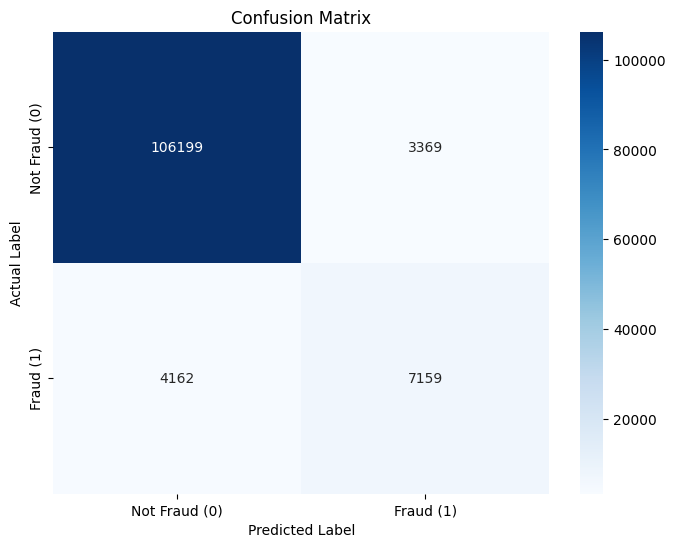

ROC-AUC: 0.9018379500774757
--- Model Performance Metrics ---
Classification Report:
               precision    recall  f1-score   support

Not Fraud (0)       0.96      0.97      0.97    109568
    Fraud (1)       0.68      0.63      0.66     11321

     accuracy                           0.94    120889
    macro avg       0.82      0.80      0.81    120889
 weighted avg       0.94      0.94      0.94    120889



In [25]:
y_pred = model.predict(X_train)
y_pred_proba = model.predict_proba(X_train)[:, 1]
#y_pred = (y_pred_proba > 0.5).astype(int)
cm = confusion_matrix(y_train, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not Fraud (0)', 'Fraud (1)'],
            yticklabels=['Not Fraud (0)', 'Fraud (1)'])
plt.title('Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

fpr, tpr, thresholds = roc_curve(y_train, y_pred_proba)
roc_auc = roc_auc_score(y_train, y_pred_proba)
print(f"ROC-AUC: {roc_auc}")
print("--- Model Performance Metrics ---")
print("Classification Report:")
print(classification_report(y_train, y_pred, target_names=['Not Fraud (0)', 'Fraud (1)']))


### On time series data

In [26]:
#min_samples_leaf=50, max_features=0.5
model_time = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42, 
                               max_depth=10, min_samples_leaf=20, max_features=0.5)

# Train the model on the training data
print("Starting model training...")
model_time.fit(X_train_time, y_train_time)
print("Model training complete.")

Starting model training...
Model training complete.


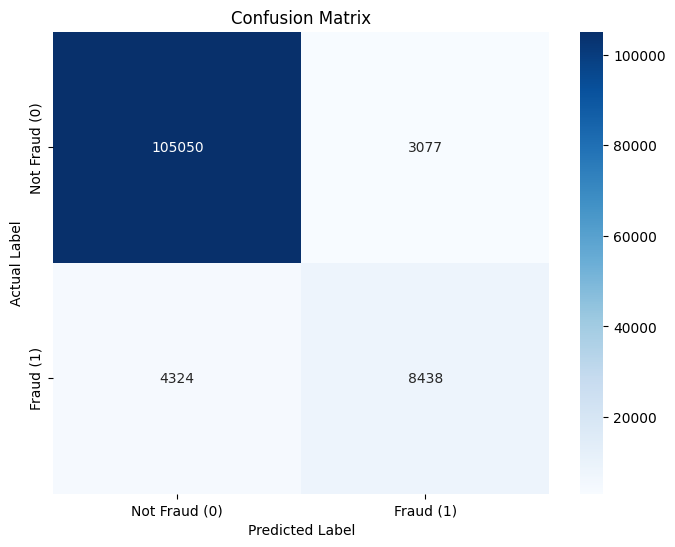

ROC-AUC: 0.9127897853932457
--- Model Performance Metrics ---
Classification Report:
               precision    recall  f1-score   support

Not Fraud (0)       0.96      0.97      0.97    108127
    Fraud (1)       0.73      0.66      0.70     12762

     accuracy                           0.94    120889
    macro avg       0.85      0.82      0.83    120889
 weighted avg       0.94      0.94      0.94    120889



In [897]:
y_pred = model_time.predict(X_train_time)
y_pred_proba = model_time.predict_proba(X_train_time)[:, 1]
#y_pred = (y_pred_proba > 0.5).astype(int)
cm = confusion_matrix(y_train_time, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not Fraud (0)', 'Fraud (1)'],
            yticklabels=['Not Fraud (0)', 'Fraud (1)'])
plt.title('Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

fpr, tpr, thresholds = roc_curve(y_train_time, y_pred_proba)
roc_auc = roc_auc_score(y_train_time, y_pred_proba)
print(f"ROC-AUC: {roc_auc}")
print("--- Model Performance Metrics ---")
print("Classification Report:")
print(classification_report(y_train_time, y_pred, target_names=['Not Fraud (0)', 'Fraud (1)']))

## Model Evaluation
The model's performance is evaluated using several metrics, including a confusion matrix, the ROC-AUC score, and a classification report. These metrics provide a comprehensive view of the model's ability to distinguish between fraudulent and non-fraudulent transactions.

### On  stratified random split

In [27]:
# Make predictions on the test data
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

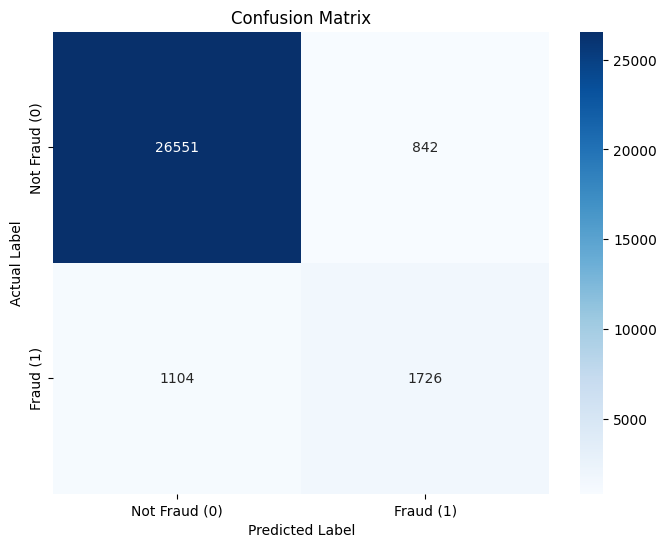

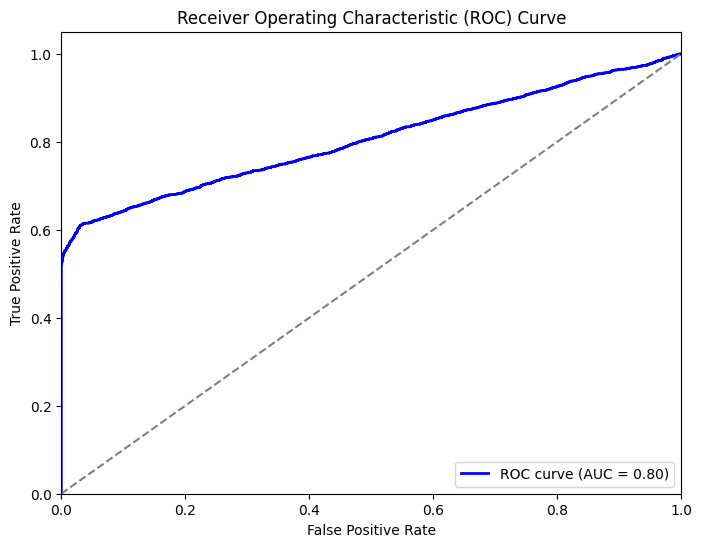

--- Model Performance Metrics ---
Classification Report:
               precision    recall  f1-score   support

Not Fraud (0)       0.96      0.97      0.96     27393
    Fraud (1)       0.67      0.61      0.64      2830

     accuracy                           0.94     30223
    macro avg       0.82      0.79      0.80     30223
 weighted avg       0.93      0.94      0.93     30223



In [28]:
# a) Confusion Matrix Visualization
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not Fraud (0)', 'Fraud (1)'],
            yticklabels=['Not Fraud (0)', 'Fraud (1)'])
plt.title('Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

# b) ROC Curve Visualization
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# --- 6. Print Performance Metrics ---
print("--- Model Performance Metrics ---")
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Not Fraud (0)', 'Fraud (1)']))

### a) Confusion Matrix and ROC Curve
The confusion matrix shows that the model is very effective at identifying non-fraudulent transactions, with a high number of true negatives. The ROC curve and the AUC score of 0.81 indicate that the model has a strong capability to distinguish between the two classes.

### b) Classification Report
The classification report provides a detailed breakdown of the model's precision and recall. The model achieves high precision for both classes and good recall for the non-fraud class. The recall for the fraud class is lower, which is common in imbalanced datasets, but still demonstrates a reasonable ability to identify fraudulent activities.

### c) Feature Importance
The feature importance highlights the most influential features in the model's predictions. As shown, `secs_since_signup`, `purchase_month` and `secs_since_dev` are the most significant feature, followed by `purchase_day`, `purchase_value` and `age`. This suggests that the time taken from signup to purchase is a strong indicator of fraudulent activity.

In [29]:
# d) Feature Importance
# features the model found most important for its predictions.
feature_importance = pd.DataFrame({
    'feature': final_features_train.columns,
    'importance': model.feature_importances_
}).sort_values(by='importance', ascending=False)
print("\nTop 5 Feature Importances:")
print(feature_importance.head())


Top 5 Feature Importances:
             feature  importance
2  secs_since_signup    0.484050
6     purchase_month    0.239670
3     secs_since_dev    0.201868
5       purchase_day    0.027936
0     purchase_value    0.013170


In [30]:
feature_importance

,feature,importance
2,secs_since_signup,0.484050
6,purchase_month,0.239670
3,secs_since_dev,0.201868
5,purchase_day,0.027936
0,purchase_value,0.013170
1,age,0.011574
4,purchase_hour,0.010287
8,source_Direct,0.002621
10,browser_Chrome,0.001294
7,source_Ads,0.001114


### On time series split

In [31]:
# Make predictions on the test data
y_pred = model_time.predict(X_test_time)
y_pred_proba = model_time.predict_proba(X_test_time)[:, 1]

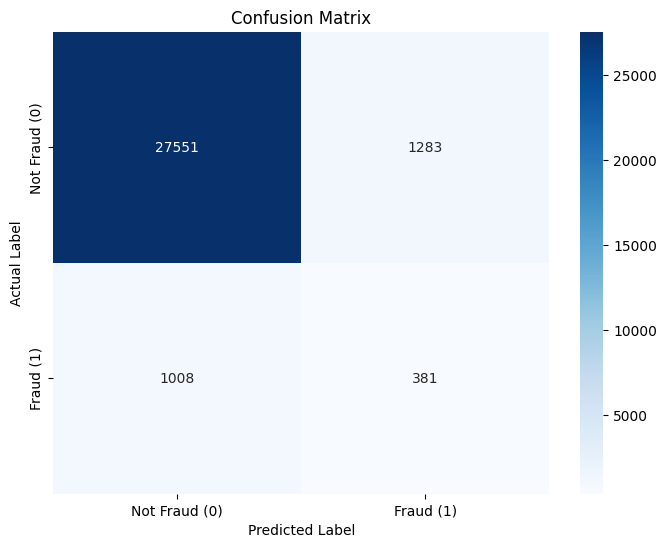

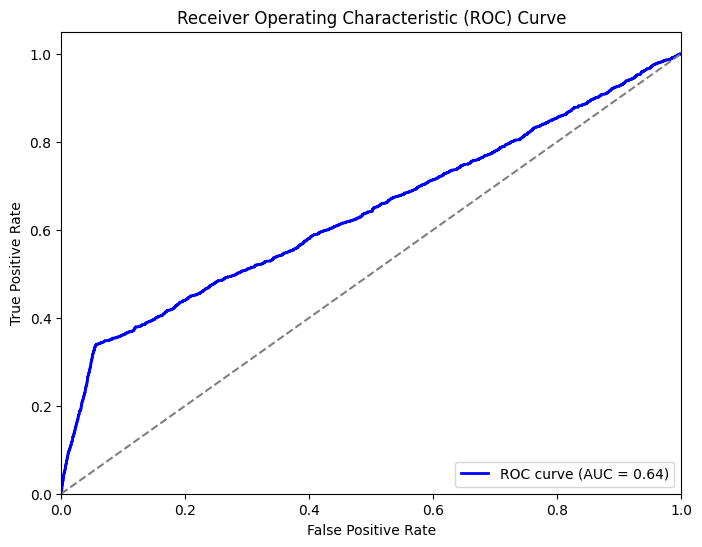

--- Model Performance Metrics ---
Classification Report:
               precision    recall  f1-score   support

Not Fraud (0)       0.96      0.96      0.96     28834
    Fraud (1)       0.23      0.27      0.25      1389

     accuracy                           0.92     30223
    macro avg       0.60      0.61      0.60     30223
 weighted avg       0.93      0.92      0.93     30223



In [32]:
# a) Confusion Matrix Visualization
cm = confusion_matrix(y_test_time, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not Fraud (0)', 'Fraud (1)'],
            yticklabels=['Not Fraud (0)', 'Fraud (1)'])
plt.title('Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

# b) ROC Curve Visualization
fpr, tpr, thresholds = roc_curve(y_test_time, y_pred_proba)
roc_auc = roc_auc_score(y_test_time, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# --- 6. Print Performance Metrics ---
print("--- Model Performance Metrics ---")
print("Classification Report:")
print(classification_report(y_test_time, y_pred, target_names=['Not Fraud (0)', 'Fraud (1)']))

In [33]:
# d) Feature Importance
# features the model found most important for its predictions.
feature_importance = pd.DataFrame({
    'feature': final_features_train_time.columns,
    'importance': model_time.feature_importances_
}).sort_values(by='importance', ascending=False)
print("\nTop 5 Feature Importances:")
print(feature_importance.head())


Top 5 Feature Importances:
             feature  importance
2  secs_since_signup    0.636049
3     secs_since_dev    0.282560
5       purchase_day    0.045006
0     purchase_value    0.010063
1                age    0.009396


In [34]:
feature_importance

,feature,importance
2,secs_since_signup,0.636049
3,secs_since_dev,0.282560
5,purchase_day,0.045006
0,purchase_value,0.010063
1,age,0.009396
4,purchase_hour,0.007653
7,source_Direct,0.002250
9,browser_Chrome,0.001121
14,sex_F,0.000895
11,browser_IE,0.000891


## Debugging the poor performance in time-stamp based split

1. It appears that main discriminating features in training data or performing very poorly on the training data
2. So checking fraud features characteristics in training and test data

In [35]:
def fraud_characteristics(df, t=1000, label_col="class"):
    """
    Computes how many fraud and non-fraud samples have secs_since_signup
    or secs_since_dev less than threshold t.
    """
    total_fraud = (df[df[label_col] == 1]).shape[0]
    total_non_fraud = (df[df[label_col] == 0]).shape[0]

    cond = (df["secs_since_signup"] < t) | (df["secs_since_dev"] < t)

    fraud_count = df[(df[label_col] == 1) & cond].shape[0]
    nonfraud_count = df[(df[label_col] == 0) & cond].shape[0]

    results = {
        "fraud_count": fraud_count,
        "fraud_rate": fraud_count / total_fraud,
        "nonfraud_count": nonfraud_count,
        "nonfraud_rate": nonfraud_count / total_non_fraud,
        "total_fraud": total_fraud,
        "total_non_fraud": total_non_fraud
    }
    return results


# --- Example usage ---
t = 1000  # threshold in seconds
train_stats = fraud_characteristics(train_df_time, t=t)
test_stats  = fraud_characteristics(test_df_time,  t=t)

print("Train period stats:")
print(f"  Fraud count={train_stats['fraud_count']} "
      f"({train_stats['fraud_rate']:.4%}) | "
      f"Non-fraud count={train_stats['nonfraud_count']} "
      f"({train_stats['nonfraud_rate']:.4%})")

print("\nTest period stats:")
print(f"  Fraud count={test_stats['fraud_count']} "
      f"({test_stats['fraud_rate']:.4%}) | "
      f"Non-fraud count={test_stats['nonfraud_count']} "
      f"({test_stats['nonfraud_rate']:.4%})")


Train period stats:
  Fraud count=7602 (59.5675%) | Non-fraud count=9 (0.0083%)

Test period stats:
  Fraud count=0 (0.0000%) | Non-fraud count=0 (0.0000%)


1. Showing correlation with `secs_since_signgup` and `secs_since_dev` have opposite correlation with the class in training and test data. 

In [36]:
tmp_train = train_df_time.copy()
tmp_train.loc[tmp_train['secs_since_dev'] == 1e9, 'secs_since_dev'] = np.nan
tmp_test = test_df_time.copy()
tmp_test.loc[tmp_test['secs_since_dev'] == 1e9, 'secs_since_dev'] = np.nan
for feature in ['secs_since_signup', 'secs_since_dev']:
    train_corr = tmp_train[[feature, 'class']].corr().iloc[0,1]
    test_corr = tmp_test[[feature, 'class']].corr().iloc[0,1]
    print(f"{feature} correlation (train vs test): {train_corr:.3f} vs {test_corr:.3f}")


secs_since_signup correlation (train vs test): -0.277 vs 0.006
secs_since_dev correlation (train vs test): -0.622 vs 0.004


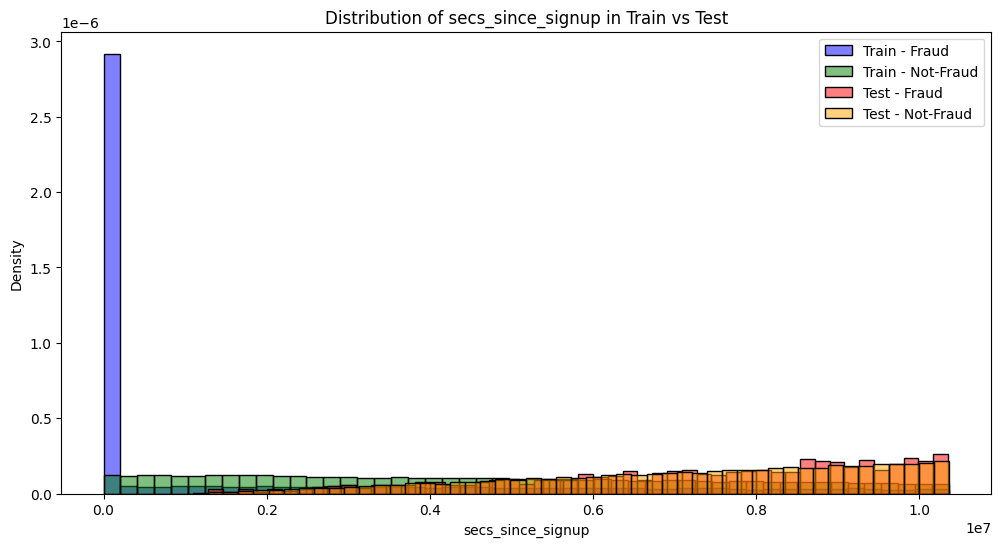

In [37]:
def plot_feature_distribution(train_df, test_df, feature, label_col='class', bins=50):
    plt.figure(figsize=(12,6))
    # Plot train Fraud
    sns.histplot(train_df[train_df[label_col]==1][feature], color='blue', bins=bins,
                 stat="density", alpha=0.5, label="Train - Fraud")
    # Plot train Not-Fraud
    sns.histplot(train_df[train_df[label_col]==0][feature], color='green', bins=bins,
                 stat="density", alpha=0.5, label="Train - Not-Fraud")
    # Plot test Fraud
    sns.histplot(test_df[test_df[label_col]==1][feature], color='red', bins=bins,
                 stat="density", alpha=0.5, label="Test - Fraud")
    # Plot test Not-Fraud
    sns.histplot(test_df[test_df[label_col]==0][feature], color='orange', bins=bins,
                 stat="density", alpha=0.5, label="Test - Not-Fraud")
    plt.title(f"Distribution of {feature} in Train vs Test")
    plt.xlabel(feature)
    plt.ylabel("Density")
    plt.legend()
    plt.show()
plot_feature_distribution(train_df_time, test_df_time,'secs_since_signup' ,label_col='class')

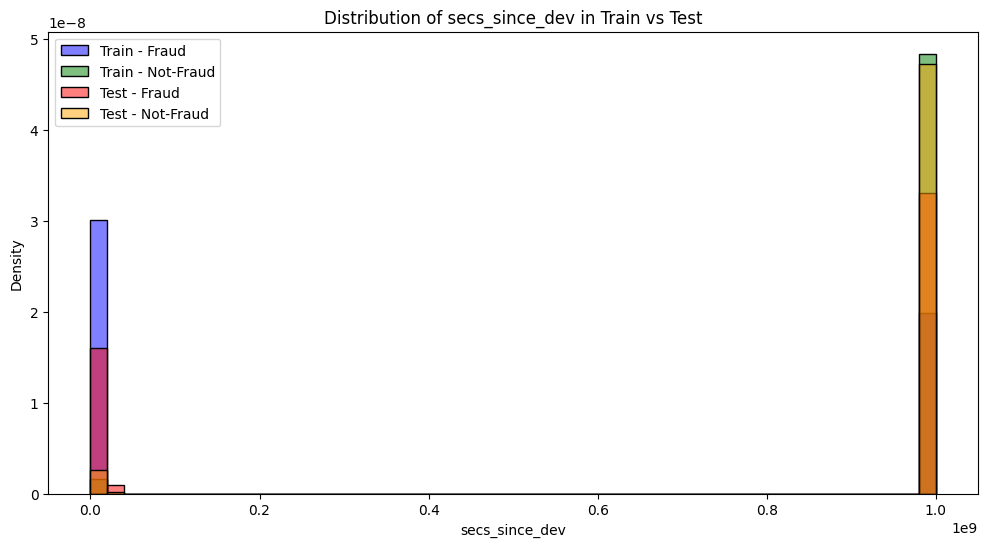

In [38]:
plot_feature_distribution(train_df_time, test_df_time,'secs_since_dev' ,label_col='class')

The current analysis has identified a significant issue: the features that were highly effective at discriminating between fraudulent and non-fraudulent transactions in the training data are not performing well on the unseen test data. This indicates a potential problem  significant shift in data distribution between the training and test sets in time series split data.